#### Note: 

 This section was originally written to play around with the data from a single participant. 

In [94]:
import os, sys

print(sys.executable) # This is where this notebook is running in
print(sys.path) # This is where the downloaded modules are - sys.executable and sys.path need to be the same to be able to load the module.

# Solution:
# Run this in Terminal: (output of sys.executable) -m pip install (package name)

/Users/jelkastojanov/anaconda3/bin/python
['/Users/jelkastojanov/Documents/GitHub/NMA/modules', '/Users/jelkastojanov/Documents/GitHub/NMA/garbage', '/Users/jelkastojanov/anaconda3/lib/python37.zip', '/Users/jelkastojanov/anaconda3/lib/python3.7', '/Users/jelkastojanov/anaconda3/lib/python3.7/lib-dynload', '', '/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages', '/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/jelkastojanov/.ipython']


In [95]:
# Load packages to convert formats
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pingouin
from sklearn import preprocessing
import numpy as np
from numpy.core import einsumfunc
import utility as ut
from nilearn import signal
import seaborn as sns
%matplotlib inline

In [ ]:
# File where the NMA fMRI data are
path_data = "/Volumes/DPhil_Jelka/fmri_data/hcp_task"

try: 
    os.chdir(path_data) 
except OSError as error: 
    print(error)  

In [ ]:
# Check if you successfully changed directory
os.getcwd() 

In [96]:
# Okay, you want hcp_task to be your specific directory for now
HCP_DIR = "/Volumes/DPhil_Jelka/fmri_data/hcp_task"
if not os.path.isdir(HCP_DIR):
    os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset (0-338)
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development. This will use all subjects.

In [97]:
# Function to load one .npy timeseries file

def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """
    Load timeseries data for a single subject and single run.
  
    Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

    Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

    """
    bold_run  = EXPERIMENTS[experiment]['runs'][run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts


def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

    Returns
    evs (list of lists): A list of frames associated with each condition

    """
    frames_list = []
    task_key = 'tfMRI_'+ experiment + '_'+['RL','LR'][run]
    for cond in EXPERIMENTS[experiment]['cond']:    
        ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    
    # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
    
    # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
    
    # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)
    
    return frames_list

In [98]:
my_exp  = 'WM'
my_subj = 2
my_run  = 0

data_example = load_single_timeseries(subject = my_subj, experiment = my_exp, run = my_run, remove_mean = True)

print(data_example.shape) # 360 ROIs, 405 timepoints
print(data_example) # np.ndarray

(360, 405)
[[   9.89654321  -45.70345679 -100.30345679 ...  -82.00345679
   -71.80345679 -104.70345679]
 [ 127.42671605   40.91671605    4.46671605 ...  -81.68328395
   -29.55328395  -37.92328395]
 [  29.50725926  -18.74274074  -35.67274074 ...    7.54725926
    82.27725926   68.85725926]
 ...
 [ 111.59012346   53.39012346  205.99012346 ...    6.89012346
   100.49012346   27.09012346]
 [  96.77901235  -37.82098765  -49.42098765 ... -122.52098765
   -42.02098765  -36.32098765]
 [  47.53679012  -26.16320988    9.93679012 ...  -76.96320988
   -34.66320988  -63.46320988]]


In [99]:
# Info about regions
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [11]:
# We want ROIs in columns
regions_T = np.transpose(regions)

In [12]:
# Check how many networks are there
from collections import Counter

# Function to get unique values
def unique(list1):
   
    # Print directly by using * symbol
    print(*Counter(list1))

unique(regions[1]) #12 networks

Visual1 Visual2 Somatomotor Cingulo-Oper Language Default Frontopariet Auditory Dorsal-atten Posterior-Mu Orbito-Affec Ventral-Mult


In [100]:
# Load explanatory variables - No clue what they current mean
evs = load_evs(subject = my_subj, experiment = my_exp, run = my_run)

In [101]:
# Turn regions into a pd.dataframe
df_regions = pd.DataFrame(regions_T, columns = ['ROI', 'Network', 'Hemi'])
print(df_regions)

         ROI       Network     Hemi
0       R_V1       Visual1    2.209
1      R_MST       Visual2  2.05561
2       R_V6       Visual2   2.1498
3       R_V2       Visual2  2.15347
4       R_V3       Visual2  2.07251
..       ...           ...      ...
355  L_STSva  Posterior-Mu   1.7608
356   L_TE1m  Frontopariet  1.74175
357     L_PI  Cingulo-Oper  1.74335
358  L_a32pr  Cingulo-Oper  1.73082
359    L_p24  Cingulo-Oper  1.65968

[360 rows x 3 columns]


In [102]:
# See how many regions you have for each network
df_regions['Network'].value_counts() # Not even close to an equal number

Posterior-Mu    77
Cingulo-Oper    56
Visual2         54
Frontopariet    50
Somatomotor     39
Language        23
Default         23
Auditory        15
Dorsal-atten     7
Orbito-Affec     6
Visual1          6
Ventral-Mult     4
Name: Network, dtype: int64

In [103]:
# Again, we want ROIs in columns
data_example_T = np.transpose(data_example)
data_example_df = pd.DataFrame(data_example_T, columns = [df_regions['ROI'], df_regions['Network']])
print(data_example_df.shape) #405 time points, 360 ROIs

(405, 360)


In [104]:
# Transform original data_example to a pd.DataFrame
data_example_df_original = pd.DataFrame(data_example)
print(data_example_df_original)

            0          1           2           3           4           5    \
0      9.896543 -45.703457 -100.303457 -140.403457 -124.403457  -99.203457   
1    127.426716  40.916716    4.466716   14.216716   64.766716   54.056716   
2     29.507259 -18.742741  -35.672741 -101.732741   -5.712741  -32.682741   
3     30.120247 -34.179753  -68.579753  -82.879753  -66.279753  -48.779753   
4     -3.957531 -37.257531  -61.157531  -86.857531  -61.657531  -48.157531   
..          ...        ...         ...         ...         ...         ...   
355  117.937037  63.037037   54.937037   53.737037   63.737037   14.137037   
356   89.855407  71.595407   -9.004593   21.285407   46.815407  -15.004593   
357  111.590123  53.390123  205.990123   51.290123  -42.209877   82.590123   
358   96.779012 -37.820988  -49.420988   16.879012    0.079012   85.479012   
359   47.536790 -26.163210    9.936790   48.936790  105.636790  125.636790   

            6          7           8           9    ...        

In [105]:
# Merge ROIs and networks
Regions_Neural = df_regions.merge(data_example_df_original, left_index=True, right_index=True)

In [23]:
Regions_Neural.head()

,ROI,Network,Hemi,0,1,2,3,4,5,6,...,395,396,397,398,399,400,401,402,403,404
0,R_V1,Visual1,2.209,9.896543,-45.703457,-100.303457,-140.403457,-124.403457,-99.203457,-100.303457,...,-113.203457,-138.503457,-130.703457,-141.503457,-145.103457,-108.803457,-112.203457,-82.003457,-71.803457,-104.703457
1,R_MST,Visual2,2.05561,127.426716,40.916716,4.466716,14.216716,64.766716,54.056716,108.866716,...,-65.103284,-93.353284,-90.103284,-130.413284,-54.813284,-75.883284,-50.523284,-81.683284,-29.553284,-37.923284
2,R_V6,Visual2,2.1498,29.507259,-18.742741,-35.672741,-101.732741,-5.712741,-32.682741,-54.012741,...,4.177259,-18.252741,-10.932741,16.087259,-45.002741,-5.552741,-19.512741,7.547259,82.277259,68.857259
3,R_V2,Visual2,2.15347,30.120247,-34.179753,-68.579753,-82.879753,-66.279753,-48.779753,-72.579753,...,-84.279753,-89.979753,-111.779753,-124.579753,-99.479753,-84.379753,-105.279753,-76.679753,-70.979753,-60.879753
4,R_V3,Visual2,2.07251,-3.957531,-37.257531,-61.157531,-86.857531,-61.657531,-48.157531,-51.657531,...,-133.157531,-135.757531,-146.357531,-154.957531,-123.657531,-125.357531,-126.757531,-129.757531,-107.657531,-115.157531


In [106]:
index_Network = np.arange(0, 360)
print(index_Network)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [18]:
columns_Network = Regions_Neural.columns
print(columns_Network)

Index([    'ROI', 'Network',    'Hemi',         0,         1,         2,
               3,         4,         5,         6,
       ...
             395,       396,       397,       398,       399,       400,
             401,       402,       403,       404],
      dtype='object', length=408)


In [ ]:
# Uncorrected full correlations between ROIs
ROI_CorrMatrix_Full = data_example_df.corr()
print(ROI_CorrMatrix_Full)

In [ ]:
# Uncorrected partial correlations between ROIs
ROI_CorrMatrix_Partial = data_example_df.pcorr()
print(ROI_CorrMatrix_Partial)

In [19]:
# The following procedure normalizes the response within ROIs over time
scaler = preprocessing.StandardScaler().fit(data_example_df)
data_example_df_zscore = scaler.transform(data_example_df)
data_example_df_zscore = pd.DataFrame(data_example_df_zscore, columns = data_example_df.columns)

In [ ]:
print(data_example_df)

In [20]:
# Sanity check - Mean
np.mean(data_example_df_zscore['R_4'])

Network
Somatomotor   -1.480297e-17
dtype: float64

In [21]:
# Sanity check - SD
np.std(data_example_df_zscore['R_4'])

Network
Somatomotor    1.0
dtype: float64

#### Note:

Data for all participants and tasks (0-back and 2-back) are downloaded, pre-processed and analysed from here.

In [107]:
# Add modules folder to Python's search path
from os import times
import sys
from pathlib import Path
from os.path import dirname, realpath, abspath
script_dir = Path(abspath(''))
module_dir = str(script_dir.parent)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)
print(script_dir)

/Users/jelkastojanov/Documents/GitHub/NMA
/Users/jelkastojanov/Documents/GitHub/NMA/garbage


In [108]:
import task
db_path = '{}/data/hcp_task'.format(module_dir)
group = task.Group(db_path)

In [109]:
# Load 0-back data - X are the features, y are the labels
X_0back, y_0back = group.extract_cons(['0bk_faces', '0bk_tools', '0bk_places', '0bk_body'])

Time taken by extract_con is 2.394129991531372 seconds
Time taken by extract_con is 0.915626049041748 seconds
Time taken by extract_con is 0.8012411594390869 seconds
Time taken by extract_con is 0.9831032752990723 seconds
Time taken by extract_cons is 5.327161073684692 seconds


In [23]:
# Sanity check
print(X_0back.shape, y_0back.shape)

(1356, 360, 78) (1356,)


In [110]:
# Load 2-back data
X_2back, y_2back = group.extract_cons(['2bk_faces', '2bk_tools', '2bk_places', '2bk_body'])

Time taken by extract_con is 0.8435328006744385 seconds
Time taken by extract_con is 0.7551469802856445 seconds
Time taken by extract_con is 0.7051777839660645 seconds
Time taken by extract_con is 0.7445549964904785 seconds
Time taken by extract_cons is 3.452713966369629 seconds


In [ ]:
print(X_2back.shape, y_2back.shape)

# 28080 - 360 (number of ROIs) x 78 (length of the time series)
# 1356 - 339 (number of subjects) x 4 (number of conditions)

#### Note:

Ignore the section below.

In [ ]:
# Create separate arrays with ROI names and time stamps
ROIs = np.array(df_regions['ROI'])
ROIs_Full = pd.DataFrame(np.repeat(ROIs, 78), columns = ['ROI'])

Timepoints = np.array(range(1,79))
Timepoints_Full = pd.DataFrame(np.tile(Timepoints, 360), columns = ['Time'])

In [ ]:
# Merge the two and create a combined column
ROIs_t = ROIs_Full.merge(Timepoints_Full, left_index=True, right_index=True)
ROIs_t['Time'] = ROIs_t['Time'].astype(str)
ROIs_t['ROI_t'] = ROIs_t['ROI'].str.cat(ROIs_t['Time'], sep ='_')

In [ ]:
# Sanity check
print(ROIs_t)

In [ ]:
# Convert the features space to pd.DataFrame
X_0back_df = pd.DataFrame(X_0back, columns = [ROIs_t['ROI_t']])
print(X_0back_df)

In [ ]:
# Add the following column: Participant 
X_0back_df['Participant'] = np.repeat(np.array(range(0,339)), 4)

In [ ]:
# Add the following column: Condition
X_0back_df['Condition'] = pd.Series(np.tile(np.array(['faces', 'tools', 'places', 'body']), 339))

In [ ]:
# Sanity check
print(X_0back_df.head())
X_0back_df.dtypes

In [ ]:
# Test if you can run classifiers in this data structure
from sklearn.linear_model import LogisticRegressionCV

# GLM
Classification = LogisticRegressionCV(cv = 8, random_state = 0, multi_class = 'multinomial', max_iter = 10000).fit(X_0back_df.iloc[:, 0:28], X_0back_df.iloc[:, 28081])

In [ ]:
# SVM
from sklearn import svm

svm.SVC().fit(X_0back_df.iloc[:, 0:28], X_0back_df.iloc[:, 28081])

#### Note:

Functional code for reshaping the dataframe can be found below.

In [111]:
rois = regions[0]
subjects = np.arange(339)
conditions_0back = ['faces', 'tools', 'places', 'body']
conditions_2back = ['faces', 'tools', 'places', 'body']

In [112]:
# Reshape the dataframe
index_0back = []
for cond in conditions_0back:
    for subj in subjects:
        for roi in rois:
            index_0back.append((cond, subj, roi))
len(index_0back)

488160

In [113]:
index_2back = []
for cond in conditions_2back:
    for subj in subjects:
        for roi in rois:
            index_2back.append((cond, subj, roi))
len(index_2back)

488160

In [114]:
# Reshape the 0-back task dataframe
X_new_0back = X_0back.reshape(488160, 78)

index_0back = pd.MultiIndex.from_tuples(index_0back)
X_df_0back = pd.DataFrame(X_new_0back, index = index_0back)
X_df_0back.index.names = ['Condition', 'Subject_id', 'ROI']

In [115]:
# Sanity check
print(X_df_0back.head())
print(X_df_0back.shape)

                                 0        1        2        3        4   \
Condition Subject_id ROI                                                  
faces     0          R_V1   12028.0  11983.2  11991.3  11979.2  12006.0   
                     R_MST  10374.7  10356.4  10295.0  10341.2  10320.6   
                     R_V6   12376.7  12335.6  12296.3  12325.5  12326.1   
                     R_V2   12099.2  12095.5  12120.9  12080.0  12093.1   
                     R_V3   11593.1  11553.0  11543.1  11552.2  11588.7   

                                 5        6        7        8        9   ...  \
Condition Subject_id ROI                                                 ...   
faces     0          R_V1   11998.1  12008.0  12009.8  11986.2  12008.8  ...   
                     R_MST  10329.0  10340.4  10283.0  10346.5  10368.5  ...   
                     R_V6   12342.4  12351.6  12299.0  12411.3  12301.9  ...   
                     R_V2   12087.4  12114.3  12112.9  12113.8  12152.6  .

In [116]:
# Reshape the 2-back task dataframe
X_new_2back = X_2back.reshape(488160, 78)

index_2back = pd.MultiIndex.from_tuples(index_2back)
X_df_2back = pd.DataFrame(X_new_2back, index = index_2back)
X_df_2back.index.names = ['Condition', 'Subject_id', 'ROI']

In [117]:
# Sanity check
print(X_df_2back.head())
print(X_df_2back.shape)

                                 0        1        2        3        4   \
Condition Subject_id ROI                                                  
faces     0          R_V1   12004.5  12000.5  12004.1  12000.5  12023.5   
                     R_MST  10417.4  10358.0  10386.2  10399.9  10351.4   
                     R_V6   12266.4  12277.7  12283.8  12232.4  12354.0   
                     R_V2   12077.8  12094.1  12080.8  12110.0  12109.9   
                     R_V3   11602.7  11603.4  11629.0  11608.6  11636.5   

                                 5        6        7        8        9   ...  \
Condition Subject_id ROI                                                 ...   
faces     0          R_V1   12060.8  12069.9  12122.1  12146.9  12136.2  ...   
                     R_MST  10418.7  10487.7  10418.0  10465.7  10435.9  ...   
                     R_V6   12397.7  12411.1  12395.5  12381.8  12325.5  ...   
                     R_V2   12154.5  12138.6  12209.3  12162.9  12216.0  .

In [118]:
# Run to unpack indices (to convert them to columns) - 0-back
X_df_0back.reset_index(level=0, inplace=True)
X_df_0back.reset_index(level=0, inplace=True)
X_df_0back.reset_index(level=0, inplace=True)

In [119]:
# Run to unpack indices (to convert them to columns) - 2-back
X_df_2back.reset_index(level=0, inplace=True)
X_df_2back.reset_index(level=0, inplace=True)
X_df_2back.reset_index(level=0, inplace=True)

In [120]:
# Add the network column
df_regions.reset_index(level=0, inplace=True)
print(df_regions)

     index      ROI       Network     Hemi
0        0     R_V1       Visual1    2.209
1        1    R_MST       Visual2  2.05561
2        2     R_V6       Visual2   2.1498
3        3     R_V2       Visual2  2.15347
4        4     R_V3       Visual2  2.07251
..     ...      ...           ...      ...
355    355  L_STSva  Posterior-Mu   1.7608
356    356   L_TE1m  Frontopariet  1.74175
357    357     L_PI  Cingulo-Oper  1.74335
358    358  L_a32pr  Cingulo-Oper  1.73082
359    359    L_p24  Cingulo-Oper  1.65968

[360 rows x 4 columns]


In [38]:
# Sanity check
print(X_df_0back.head())
print(X_df_0back.shape)

     ROI  Subject_id Condition        0        1        2        3        4  \
0   R_V1           0     faces  12028.0  11983.2  11991.3  11979.2  12006.0   
1  R_MST           0     faces  10374.7  10356.4  10295.0  10341.2  10320.6   
2   R_V6           0     faces  12376.7  12335.6  12296.3  12325.5  12326.1   
3   R_V2           0     faces  12099.2  12095.5  12120.9  12080.0  12093.1   
4   R_V3           0     faces  11593.1  11553.0  11543.1  11552.2  11588.7   

         5        6  ...       68       69       70       71       72  \
0  11998.1  12008.0  ...  12078.0  12048.5  12029.4  12021.9  12003.7   
1  10329.0  10340.4  ...  10367.6  10343.9  10358.8  10380.3  10395.0   
2  12342.4  12351.6  ...  12424.0  12465.6  12482.8  12499.3  12472.8   
3  12087.4  12114.3  ...  12119.4  12123.8  12135.1  12107.3  12083.2   
4  11567.7  11579.6  ...  11598.3  11609.5  11624.7  11638.2  11580.7   

        73       74       75       76       77  
0  11981.9  12006.8  11996.9  12034.0

In [121]:
# Adding the information about the brain network to the data frame
X_0back_full = X_df_0back.merge(df_regions, left_on='ROI', right_on='ROI')
X_2back_full = X_df_2back.merge(df_regions, left_on='ROI', right_on='ROI')

In [122]:
# Sanity check
X_0back_full.head()

,ROI,Subject_id,Condition,0,1,2,3,4,5,6,...,71,72,73,74,75,76,77,index,Network,Hemi
0,R_V1,0,faces,12028.00,11983.20,11991.30,11979.20,12006.00,11998.1,12008.00,...,12021.90,12003.70,11981.90,12006.80,11996.90,12034.00,12051.10,0,Visual1,2.209
1,R_V1,1,faces,9663.47,9690.52,9682.68,9653.18,9666.53,9698.1,9670.03,...,9680.88,9668.43,9641.42,9651.17,9621.19,9628.23,9635.76,0,Visual1,2.209
2,R_V1,2,faces,10948.80,10945.20,10931.50,10923.60,10973.60,10961.0,10985.00,...,10986.70,10985.20,11004.30,10956.50,10963.70,10980.10,10975.30,0,Visual1,2.209
3,R_V1,3,faces,11508.60,11518.10,11465.00,11477.70,11469.70,11524.6,11527.30,...,11719.50,11737.20,11684.80,11738.30,11735.60,11705.20,11721.20,0,Visual1,2.209
4,R_V1,4,faces,11814.20,11780.40,11793.60,11780.60,11783.40,11801.0,11841.90,...,11412.90,11448.60,11434.10,11434.60,11371.30,11365.40,11371.70,0,Visual1,2.209


In [123]:
# Sanity check
X_2back_full.head()

,ROI,Subject_id,Condition,0,1,2,3,4,5,6,...,71,72,73,74,75,76,77,index,Network,Hemi
0,R_V1,0,faces,12004.50,12000.50,12004.10,12000.50,12023.50,12060.80,12069.90,...,12157.90,12134.10,12170.20,12142.10,12151.80,12126.50,12158.70,0,Visual1,2.209
1,R_V1,1,faces,9667.16,9649.17,9678.08,9662.16,9649.98,9615.69,9627.43,...,9724.27,9738.19,9735.02,9716.98,9751.03,9728.04,9706.46,0,Visual1,2.209
2,R_V1,2,faces,10919.50,10912.50,10885.30,10913.40,10922.50,10946.30,10940.10,...,11020.00,11024.20,11025.00,11014.30,10997.30,10999.80,11018.60,0,Visual1,2.209
3,R_V1,3,faces,11495.60,11472.30,11534.30,11518.80,11514.30,11561.60,11562.70,...,11825.60,11812.40,11807.60,11804.40,11757.80,11750.10,11763.40,0,Visual1,2.209
4,R_V1,4,faces,11726.70,11802.10,11779.90,11769.50,11790.20,11787.40,11832.50,...,11352.20,11371.60,11327.40,11346.90,11340.70,11344.00,11368.90,0,Visual1,2.209


In [124]:
# Set indices
X_0back_full = X_0back_full.set_index(['Subject_id', 'Condition', 'ROI', 'Network'])
X_2back_full = X_2back_full.set_index(['Subject_id', 'Condition', 'ROI', 'Network'])

In [125]:
# Delete unnecessary columns
del X_0back_full["index"]
del X_0back_full["Hemi"]
del X_2back_full["index"]
del X_2back_full["Hemi"]

In [126]:
X_2back_0back_contr_ROI = X_2back_full - X_0back_full

In [127]:
# Sanity check
X_2back_0back_contr_ROI.head()

,,,,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
Subject_id,Condition,ROI,Network,,,,,,,,,,,,,,,,,,,,,
0,faces,R_V1,Visual1,-23.50,17.30,12.8,21.30,17.50,62.70,61.9,112.30,160.70,127.40,...,94.4,97.60,146.90,136.00,130.40,188.3,135.30,154.90,92.50,107.6
1,faces,R_V1,Visual1,3.69,-41.35,-4.6,8.98,-16.55,-82.41,-42.6,-57.13,-58.66,-36.18,...,63.5,55.57,66.56,43.39,69.76,93.6,65.81,129.84,99.81,70.7
2,faces,R_V1,Visual1,-29.30,-32.70,-46.2,-10.20,-51.10,-14.70,-44.9,-28.60,15.80,45.10,...,67.7,58.10,104.20,33.30,39.00,20.7,57.80,33.60,19.70,43.3
3,faces,R_V1,Visual1,-13.00,-45.80,69.3,41.10,44.60,37.00,35.4,-22.40,34.40,1.30,...,78.1,50.50,52.90,106.10,75.20,122.8,66.10,22.20,44.90,42.2
4,faces,R_V1,Visual1,-87.50,21.70,-13.7,-11.10,6.80,-13.60,-9.4,-17.90,-46.70,-58.30,...,-19.4,-23.90,-46.60,-60.70,-77.00,-106.7,-87.70,-30.60,-21.40,-2.8


#### Note: 

Calculate the mean activity on the network level.

In [128]:
# Group by condition, network and participant and calculate the mean network activity at each of the 78 time steps
X_0back_full_net = X_0back_full.groupby(['Subject_id', 'Condition', 'Network']).mean()
X_2back_full_net = X_2back_full.groupby(['Subject_id', 'Condition', 'Network']).mean()

In [129]:
# 339 (subj) x 4 (cond) x 12 (net) = 16272 rows
X_0back_full_net.shape

(16272, 78)

In [130]:
# Sanity check
X_0back_full_net.head()

0             1             2   \
Subject_id Condition Network                                                  
0          body      Auditory      10570.910667  10559.482667  10558.042667   
                     Cingulo-Oper  11404.612143  11397.947500  11405.201250   
                     Default       10302.066087  10315.360435  10316.175217   
                     Dorsal-atten  10436.618571  10437.545714  10429.855714   
                     Frontopariet  10976.498000  10976.870400  10979.375600   

                                             3             4             5   \
Subject_id Condition Network                                                  
0          body      Auditory      10557.971333  10569.071333  10575.828667   
                     Cingulo-Oper  11412.923036  11407.661429  11411.467500   
                     Default       10319.676522  10305.984783  10312.207391   
                     Dorsal-atten  10442.552857  10440.542857  10467.337143   
                     Frontopariet  10989.695800  10992.549800  11001.456600   

                                             6             7             8   \
Subject_id Condition Network                                                  
0          body      Auditory      10597.588667  10548.816000  10557.684667   
                     Cingulo-Oper  11409.143214  11409.967500  11416.129107   
                     Default       10331.403043  10331.197391  10324.156087   
                     Dorsal-atten  10493.134286  10476.871429  10461.774286   
                     Frontopariet  11014.737800  10986.691000  10981.526000   

                                             9   ...            68  \
Subject_id Condition Network                     ...                 
0          body      Auditory      10530.911333  ...  10537.397333   
                     Cingulo-Oper  11426.297857  ...  11191.768214   
                     Default       10331.242609  ...  10332.352174   
                     Dorsal-atten  10481.645714  ...  10344.114286   
                     Frontopariet  10992.998000  ...  10622.288000   

                                             69            70            71  \
Subject_id Condition Network                                                  
0          body      Auditory      10533.365333  10545.706667  10537.018667   
                     Cingulo-Oper  11197.067857  11194.273929  11182.231071   
                     Default       10348.643913  10341.022174  10325.472609   
                     Dorsal-atten  10351.944286  10383.840000  10349.467143   
                     Frontopariet  10639.027400  10635.935400  10619.900600   

                                             72            73            74  \
Subject_id Condition Network                                                  
0          body      Auditory      10525.060667  10566.845333  10558.225333   
                     Cingulo-Oper  11174.226964  11193.356786  11200.759107   
                     Default       10336.795217  10330.170000  10345.498696   
                     Dorsal-atten  10362.028571  10356.758571  10358.641429   
                     Frontopariet  10626.532600  10621.213600  10636.832000   

                                             75            76            77  
Subject_id Condition Network                                                 
0          body      Auditory      10555.538667  10565.348000  10548.770667  
                     Cingulo-Oper  11195.005714  11199.488214  11212.151607  
                     Default       10332.387391  10347.660435  10340.260435  
                     Dorsal-atten  10358.995714  10341.261429  10370.198571  
                     Frontopariet  10629.505400  10625.407200  10645.620800  

[5 rows x 78 columns]

In [131]:
# Return indices to columns (0-back)
X_0back_full_net.reset_index(level=0, inplace=True)
X_0back_full_net.reset_index(level=0, inplace=True)
X_0back_full_net.reset_index(level=0, inplace=True)

In [132]:
# Return indices to columns (2-back)
X_2back_full_net.reset_index(level=0, inplace=True)
X_2back_full_net.reset_index(level=0, inplace=True)
X_2back_full_net.reset_index(level=0, inplace=True)

In [133]:
# Sanity check
X_0back_full_net.head()

,Network,Condition,Subject_id,0,1,2,3,4,5,6,...,68,69,70,71,72,73,74,75,76,77
0,Auditory,body,0,10570.910667,10559.482667,10558.042667,10557.971333,10569.071333,10575.828667,10597.588667,...,10537.397333,10533.365333,10545.706667,10537.018667,10525.060667,10566.845333,10558.225333,10555.538667,10565.348000,10548.770667
1,Cingulo-Oper,body,0,11404.612143,11397.947500,11405.201250,11412.923036,11407.661429,11411.467500,11409.143214,...,11191.768214,11197.067857,11194.273929,11182.231071,11174.226964,11193.356786,11200.759107,11195.005714,11199.488214,11212.151607
2,Default,body,0,10302.066087,10315.360435,10316.175217,10319.676522,10305.984783,10312.207391,10331.403043,...,10332.352174,10348.643913,10341.022174,10325.472609,10336.795217,10330.170000,10345.498696,10332.387391,10347.660435,10340.260435
3,Dorsal-atten,body,0,10436.618571,10437.545714,10429.855714,10442.552857,10440.542857,10467.337143,10493.134286,...,10344.114286,10351.944286,10383.840000,10349.467143,10362.028571,10356.758571,10358.641429,10358.995714,10341.261429,10370.198571
4,Frontopariet,body,0,10976.498000,10976.870400,10979.375600,10989.695800,10992.549800,11001.456600,11014.737800,...,10622.288000,10639.027400,10635.935400,10619.900600,10626.532600,10621.213600,10636.832000,10629.505400,10625.407200,10645.620800


In [134]:
# Sanity check
X_2back_full_net.head()

,Network,Condition,Subject_id,0,1,2,3,4,5,6,...,68,69,70,71,72,73,74,75,76,77
0,Auditory,body,0,10513.302667,10510.148000,10535.079333,10521.920000,10515.240667,10529.814667,10548.097333,...,10547.381333,10548.404667,10581.230667,10578.819333,10552.318000,10553.810000,10557.700000,10547.729333,10555.196000,10572.920667
1,Cingulo-Oper,body,0,11359.838393,11350.669643,11362.828036,11357.317143,11354.753036,11354.653036,11372.082679,...,11184.943571,11190.940714,11186.418750,11194.230893,11187.954643,11196.669643,11194.907500,11183.193929,11209.787500,11206.237500
2,Default,body,0,10280.175217,10277.216522,10268.863913,10280.523478,10267.522174,10282.300870,10301.117391,...,10348.343478,10356.838261,10364.836957,10358.145217,10355.730000,10362.967391,10361.825217,10340.093913,10340.578696,10358.893913
3,Dorsal-atten,body,0,10407.442857,10426.668571,10380.267143,10386.244286,10394.920000,10415.598571,10426.321429,...,10369.707143,10384.895714,10395.381429,10389.944286,10396.580000,10404.450000,10411.432857,10394.377143,10414.470000,10411.192857
4,Frontopariet,body,0,10888.065600,10873.332200,10855.890200,10869.319600,10884.365800,10897.929400,10929.934000,...,10657.163000,10687.228600,10686.270600,10684.482400,10675.743600,10698.277000,10689.713600,10680.966000,10680.650800,10679.955400


#### Note:

Ignore the code below - DO NOT rename the columns as that will throw an error when you try to subtract the 2-back and 0-back dataframes.

In [54]:
# Rename time point columns
cols_0back = X_0back_full_net.columns
cols_2back = X_2back_full_net.columns

In [55]:
cols_0back = np.asarray(cols_0back, dtype=str)
cols_2back = np.asarray(cols_2back, dtype=str)

In [ ]:
cols_0back = np.core.defchararray.add(cols_0back, '_0_back')
cols_2back = np.core.defchararray.add(cols_2back, '_2_back')

cols_0back[0] = 'Network'
cols_0back[1] = 'Condition'
cols_0back[2] = 'Subject_id'

cols_2back[0] = 'Network'
cols_2back[1] = 'Condition'
cols_2back[2] = 'Subject_id'

In [ ]:
# Sanity check
print(cols_0back)
print(cols_2back)

In [ ]:
# Change the column names
X_0back_full_net.columns = cols_0back
X_2back_full_net.columns = cols_2back

In [ ]:
# Sanity check
X_0back_full_net.head()

In [ ]:
# Sanity check
X_2back_full_net.head()

In [ ]:
# Merge 0-back and 2-back tasks
X_0back_2back = X_0back_full_net.merge(X_2back_full_net, left_on=['Network', 'Condition', 'Subject_id'], right_on=['Network', 'Condition', 'Subject_id'])

In [ ]:
# Sanity check
X_0back_2back.head(12)

#### Note:

Create a contrast dataframe.

In [135]:
# Contrast 2-back - 0-back
X_0back_full_net = X_0back_full_net.set_index(['Network', 'Condition', 'Subject_id'])
X_2back_full_net = X_2back_full_net.set_index(['Network', 'Condition', 'Subject_id'])

In [57]:
# Sanity check
X_0back_full_net.head()

,,,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
Network,Condition,Subject_id,,,,,,,,,,,,,,,,,,,,,
Auditory,body,0,10570.910667,10559.482667,10558.042667,10557.971333,10569.071333,10575.828667,10597.588667,10548.816000,10557.684667,10530.911333,...,10537.397333,10533.365333,10545.706667,10537.018667,10525.060667,10566.845333,10558.225333,10555.538667,10565.348000,10548.770667
Cingulo-Oper,body,0,11404.612143,11397.947500,11405.201250,11412.923036,11407.661429,11411.467500,11409.143214,11409.967500,11416.129107,11426.297857,...,11191.768214,11197.067857,11194.273929,11182.231071,11174.226964,11193.356786,11200.759107,11195.005714,11199.488214,11212.151607
Default,body,0,10302.066087,10315.360435,10316.175217,10319.676522,10305.984783,10312.207391,10331.403043,10331.197391,10324.156087,10331.242609,...,10332.352174,10348.643913,10341.022174,10325.472609,10336.795217,10330.170000,10345.498696,10332.387391,10347.660435,10340.260435
Dorsal-atten,body,0,10436.618571,10437.545714,10429.855714,10442.552857,10440.542857,10467.337143,10493.134286,10476.871429,10461.774286,10481.645714,...,10344.114286,10351.944286,10383.840000,10349.467143,10362.028571,10356.758571,10358.641429,10358.995714,10341.261429,10370.198571
Frontopariet,body,0,10976.498000,10976.870400,10979.375600,10989.695800,10992.549800,11001.456600,11014.737800,10986.691000,10981.526000,10992.998000,...,10622.288000,10639.027400,10635.935400,10619.900600,10626.532600,10621.213600,10636.832000,10629.505400,10625.407200,10645.620800


In [58]:
# Sanity check
X_2back_full_net.head()

,,,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
Network,Condition,Subject_id,,,,,,,,,,,,,,,,,,,,,
Auditory,body,0,10513.302667,10510.148000,10535.079333,10521.920000,10515.240667,10529.814667,10548.097333,10561.133333,10554.373333,10564.174000,...,10547.381333,10548.404667,10581.230667,10578.819333,10552.318000,10553.810000,10557.700000,10547.729333,10555.196000,10572.920667
Cingulo-Oper,body,0,11359.838393,11350.669643,11362.828036,11357.317143,11354.753036,11354.653036,11372.082679,11388.209643,11399.702857,11410.989464,...,11184.943571,11190.940714,11186.418750,11194.230893,11187.954643,11196.669643,11194.907500,11183.193929,11209.787500,11206.237500
Default,body,0,10280.175217,10277.216522,10268.863913,10280.523478,10267.522174,10282.300870,10301.117391,10311.949130,10314.795652,10310.440435,...,10348.343478,10356.838261,10364.836957,10358.145217,10355.730000,10362.967391,10361.825217,10340.093913,10340.578696,10358.893913
Dorsal-atten,body,0,10407.442857,10426.668571,10380.267143,10386.244286,10394.920000,10415.598571,10426.321429,10443.237143,10453.041429,10457.281429,...,10369.707143,10384.895714,10395.381429,10389.944286,10396.580000,10404.450000,10411.432857,10394.377143,10414.470000,10411.192857
Frontopariet,body,0,10888.065600,10873.332200,10855.890200,10869.319600,10884.365800,10897.929400,10929.934000,10956.846200,10962.209800,10965.212200,...,10657.163000,10687.228600,10686.270600,10684.482400,10675.743600,10698.277000,10689.713600,10680.966000,10680.650800,10679.955400


In [136]:
# Create a contrast dataframe
X_2back_0back_contr = X_2back_full_net - X_0back_full_net

In [137]:
X_2back_0back_contr.head()

,,,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
Network,Condition,Subject_id,,,,,,,,,,,,,,,,,,,,,
Auditory,body,0,-57.608000,-49.334667,-22.963333,-36.051333,-53.830667,-46.014000,-49.491333,12.317333,-3.311333,33.262667,...,9.984000,15.039333,35.524000,41.800667,27.257333,-13.035333,-0.525333,-7.809333,-10.152000,24.150000
Cingulo-Oper,body,0,-44.773750,-47.277857,-42.373214,-55.605893,-52.908393,-56.814464,-37.060536,-21.757857,-16.426250,-15.308393,...,-6.824643,-6.127143,-7.855179,11.999821,13.727679,3.312857,-5.851607,-11.811786,10.299286,-5.914107
Default,body,0,-21.890870,-38.143913,-47.311304,-39.153043,-38.462609,-29.906522,-30.285652,-19.248261,-9.360435,-20.802174,...,15.991304,8.194348,23.814783,32.672609,18.934783,32.797391,16.326522,7.706522,-7.081739,18.633478
Dorsal-atten,body,0,-29.175714,-10.877143,-49.588571,-56.308571,-45.622857,-51.738571,-66.812857,-33.634286,-8.732857,-24.364286,...,25.592857,32.951429,11.541429,40.477143,34.551429,47.691429,52.791429,35.381429,73.208571,40.994286
Frontopariet,body,0,-88.432400,-103.538200,-123.485400,-120.376200,-108.184000,-103.527200,-84.803800,-29.844800,-19.316200,-27.785800,...,34.875000,48.201200,50.335200,64.581800,49.211000,77.063400,52.881600,51.460600,55.243600,34.334600


In [138]:
# Return indices to columns (2-back)
X_2back_0back_contr.reset_index(level=0, inplace=True)
X_2back_0back_contr.reset_index(level=0, inplace=True)
X_2back_0back_contr.reset_index(level=0, inplace=True)

In [139]:
X_2back_0back_contr_ROI.reset_index(level=0, inplace=True)
X_2back_0back_contr_ROI.reset_index(level=0, inplace=True)
X_2back_0back_contr_ROI.reset_index(level=0, inplace=True)
X_2back_0back_contr_ROI.reset_index(level=0, inplace=True)

In [140]:
# Split the networks - Original ROI activity
Visual1 = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Visual1']
Visual2 = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Visual2']
Somatomotor = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Somatomotor']
Cingulo_Oper = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Cingulo-Oper']
Language = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Language']
Default = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Default']
Frontopariet = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Frontopariet']
Auditory = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Auditory']
Dorsal_atten = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Dorsal-atten']
Posterior_Mu = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Posterior-Mu']
Orbito_Affec = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Orbito-Affec']
Ventral_Mult = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Ventral-Mult']

In [141]:
# Split the networks - Mean activity
Visual1_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Visual1']
Visual2_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Visual2']
Somatomotor_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Somatomotor']
Cingulo_Oper_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Cingulo-Oper']
Language_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Language']
Default_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Default']
Frontopariet_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Frontopariet']
Auditory_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Auditory']
Dorsal_atten_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Dorsal-atten']
Posterior_Mu_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Posterior-Mu']
Orbito_Affec_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Orbito-Affec']
Ventral_Mult_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Ventral-Mult']

In [65]:
Visual2.head(12)

,Network,ROI,Condition,Subject_id,0,1,2,3,4,5,...,68,69,70,71,72,73,74,75,76,77
1356,Visual2,R_MST,faces,0,42.70,1.60,91.20,58.70,30.80,89.70,...,15.20,39.90,-9.00,63.90,0.70,50.20,4.00,67.50,37.40,12.50
1357,Visual2,R_MST,faces,1,-29.84,18.53,-31.15,1.97,-34.72,-12.13,...,34.29,3.60,18.03,-39.59,8.46,46.73,70.35,65.33,54.02,41.26
1358,Visual2,R_MST,faces,2,13.54,-77.83,-0.83,-75.95,6.67,-30.09,...,43.26,1.98,17.40,39.81,39.01,45.92,60.35,-46.96,17.12,12.03
1359,Visual2,R_MST,faces,3,44.92,22.77,8.96,39.73,-74.87,40.13,...,74.31,26.80,88.28,106.57,-6.45,69.33,85.23,23.25,38.74,9.21
1360,Visual2,R_MST,faces,4,-178.10,-131.20,-200.90,-137.30,-174.50,-164.50,...,8.60,-10.60,-69.40,23.40,-162.10,-112.50,-79.70,-62.80,17.30,64.10
1361,Visual2,R_MST,faces,5,29.56,-4.60,33.24,9.22,-9.16,-22.34,...,-41.86,17.94,40.20,13.06,-6.67,60.78,67.54,-58.86,-14.45,67.57
1362,Visual2,R_MST,faces,6,65.75,82.96,83.67,60.55,96.42,70.80,...,28.93,-30.85,-87.07,21.99,-62.65,-46.40,-57.28,-70.46,-67.53,-108.94
1363,Visual2,R_MST,faces,7,-70.72,-11.99,-57.31,-122.58,-81.80,-17.85,...,-5.40,-45.08,-45.11,3.37,-7.68,-14.21,1.70,15.60,9.13,-12.15
1364,Visual2,R_MST,faces,8,-22.97,-58.22,-12.63,-27.37,-18.89,-24.25,...,3.91,-1.21,-143.02,36.15,57.52,-81.06,-150.69,12.69,-86.05,-141.69
1365,Visual2,R_MST,faces,9,-83.97,-19.18,-34.02,-75.43,17.92,-22.16,...,-137.96,-174.21,-150.85,-228.97,-156.22,-223.98,-270.39,-192.50,-254.52,-189.45


In [66]:
Visual2_mean.head(12)

,Subject_id,Condition,Network,0,1,2,3,4,5,6,...,68,69,70,71,72,73,74,75,76,77
11,0,body,Visual2,-3.607407,-10.931481,-7.214815,-47.645741,-51.474074,-62.754074,-91.821481,...,28.232963,22.613704,24.625556,16.057778,6.462037,-4.530556,7.424074,-3.495000,19.622778,20.024074
23,0,faces,Visual2,13.390185,37.366852,37.070000,28.285370,36.322037,29.073333,27.559630,...,81.796667,76.416481,98.559630,88.224259,77.445926,78.972222,101.566852,111.010000,86.461667,75.451852
35,0,places,Visual2,-34.348889,-36.575000,-33.681481,-46.895185,-80.123519,-84.533148,-93.008519,...,-49.590370,-31.722222,-17.316111,10.305926,7.691481,28.383148,42.388889,4.655000,16.852593,-0.552037
47,0,tools,Visual2,-20.753333,2.430741,33.306667,71.204074,103.899444,69.708519,22.531852,...,24.234259,24.549259,-1.071111,-12.052963,-23.698704,16.854815,39.316852,32.021667,49.406111,75.030926
59,1,body,Visual2,-31.268889,-56.462778,-55.969630,-47.154074,-32.855000,-21.134444,-24.807222,...,-19.331667,15.488148,-2.783148,-35.139630,-38.497593,-29.020370,-43.212778,-56.997593,-55.122222,-46.978704
71,1,faces,Visual2,-67.159630,-61.589815,-53.539815,-65.684259,-73.891481,-95.873148,-83.621296,...,49.159444,66.305185,73.583704,73.623704,63.570926,83.950926,89.534444,95.534259,67.605926,73.748519
83,1,places,Visual2,-40.489444,-5.580000,23.472037,22.206296,1.755185,-38.569444,-45.710926,...,-6.319444,7.571481,15.360741,25.779630,45.577593,37.615556,43.033519,9.422593,-22.328704,-46.665185
95,1,tools,Visual2,5.203704,-8.340370,-0.077222,6.343333,20.336296,0.234444,-6.525926,...,24.808333,25.724074,11.482407,26.283519,34.252778,28.106111,15.113148,15.258333,-4.578333,13.512037
107,2,body,Visual2,-5.808704,-33.031667,-17.879630,-20.068519,-21.595741,-25.275185,-42.127407,...,11.858148,40.294259,51.170185,46.883519,43.200926,37.489815,27.415926,42.401852,40.809074,25.513148
119,2,faces,Visual2,-52.503519,-47.090741,-53.570926,-45.723519,-67.766111,-50.779815,-76.796481,...,40.111667,38.292963,58.110000,47.391481,22.541296,25.939630,36.347963,27.633519,22.660185,13.665926


#### NEXT STEPS:

In [ ]:
# TO DO:
# NORMALIZING DATA - It is very important to figure out what is meant by this and how to execute it.
# NORMALIZING DATA - This might probably need to be done before creating contrasts or anything.
# WITHIN-NETWORK CLASSIFICATION - Doing the classification within each network + Regularization?
# CROSS-VALIDATION - Are we 'manually' splitting the data into train/test or is the function doing that for us?
# REGULARIZATION - L2 applied everywhere

In [142]:
# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

#### Note:
Fitting the GLM

In [230]:
# Define the model - Same for all networks
# Dimensionality:
# 1) ROI-level
# 2) Average network activity
model = LogisticRegression(multi_class = 'multinomial', max_iter = 10000, solver='lbfgs', penalty='l2', C=1)

# Define the model evaluation procedure - Same for all networks
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#### Note: 

Network-by-network analysis (with ROI-level activity)

In [ ]:
# Evaluate the model and collect the scores - Visual 1
n_scores_V1_ROI = cross_val_score(model, Visual1.iloc[:, 4:82], Visual1.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.480, SD = 0.018)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V1_ROI), np.std(n_scores_V1_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Visual 2
n_scores_V2_ROI = cross_val_score(model, Visual2.iloc[:, 4:82], Visual2.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.526, SD = 0.005)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V2_ROI), np.std(n_scores_V2_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Somatomotor
n_scores_SM_ROI = cross_val_score(model, Somatomotor.iloc[:, 4:82], Somatomotor.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.404, SD = 0.007)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_SM_ROI), np.std(n_scores_SM_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Cingulo-Oper
n_scores_CO_ROI = cross_val_score(model, Cingulo_Oper.iloc[:, 4:82], Cingulo_Oper.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.412, SD = 0.005)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_CO_ROI), np.std(n_scores_CO_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Language
n_scores_LA_ROI = cross_val_score(model, Language.iloc[:, 4:82], Language.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.51, SD = 0.008)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_LA_ROI), np.std(n_scores_LA_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Default
n_scores_DE_ROI = cross_val_score(model, Default.iloc[:, 4:82], Default.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.424, SD = 0.009)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_DE_ROI), np.std(n_scores_DE_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Frontopariet
n_scores_FP_ROI = cross_val_score(model, Frontopariet.iloc[:, 4:82], Frontopariet.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.468, SD = 0.008)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_FP_ROI), np.std(n_scores_FP_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Auditory
n_scores_AU_ROI = cross_val_score(model, Auditory.iloc[:, 4:82], Auditory.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.459, SD = 0.010)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_AU_ROI), np.std(n_scores_AU_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Dorsal-atten
n_scores_DA_ROI = cross_val_score(model, Dorsal_atten.iloc[:, 4:82], Dorsal_atten.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.414, SD = 0.016)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_DA_ROI), np.std(n_scores_DA_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Posterior-Mu
n_scores_PM_ROI = cross_val_score(model, Posterior_Mu.iloc[:, 4:82], Posterior_Mu.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.397, SD = 0.004)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_PM_ROI), np.std(n_scores_PM_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Orbito-Affec
n_scores_OA_ROI = cross_val_score(model, Orbito_Affec.iloc[:, 4:82], Orbito_Affec.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.329, SD = 0.016)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_OA_ROI), np.std(n_scores_OA_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Ventral-Mult
n_scores_VM_ROI = cross_val_score(model, Ventral_Mult.iloc[:, 4:82], Ventral_Mult.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.423, SD = 0.018)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_VM_ROI), np.std(n_scores_VM_ROI)))

#### Note: 

Network-by-network analysis (with mean network-level activity)

In [69]:
# Evaluate the model and collect the scores - Visual 1
n_scores_V1 = cross_val_score(model, Visual1_mean.iloc[:, 3:81], Visual1_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.51, SD = 0.034)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V1), np.std(n_scores_V1)))

Mean Accuracy: 0.507 (0.034)


#### FOCUS ON VISUAL 2:

In [231]:
# Evaluate the model and collect the scores - Visual 2
n_scores_V2 = cross_val_score(model, Visual2_mean.iloc[:, 3:81], Visual2_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.653, SD = 0.040)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V2), np.std(n_scores_V2)))

Mean Accuracy: 0.653 (0.040)


In [232]:
# Visual 2
model.fit(Visual2_mean.iloc[:, 3:81], Visual2_mean.iloc[:, 1])
model.coef_.shape #(4,78) - 4 classes, 78 features
model.intercept_.shape #4

(4,)

In [233]:
# Visual 2
# Split into the training and testing set
X_train,X_test,y_train,y_test=train_test_split(Visual2_mean.iloc[:, 3:81], Visual2_mean.iloc[:, 1], test_size=0.25, random_state=0)

In [234]:
# Instantiate the model 
logreg = LogisticRegression(multi_class = 'multinomial', max_iter = 10000, solver='lbfgs', penalty='l2', C=1)

# Fit the model with data
logreg.fit(X_train,y_train)

# Predict 
y_pred = logreg.predict(X_test)

In [ ]:
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)

y_test_lb = lb.transform(y_test)
y_pred_lb = lb.transform(y_pred)

roc_auc_score(y_test_lb, y_pred_lb, average='macro')

In [236]:
# Visually compare output
output = pd.DataFrame()
output['Expected Output'] = y_test
output['Predicted Output'] = y_pred
output.head(20)

,Expected Output,Predicted Output
10067,places,places
7595,body,body
11975,faces,places
10967,faces,tools
9551,tools,tools
6983,faces,tools
7991,faces,faces
2903,faces,faces
6695,faces,faces
15587,places,places


In [237]:
from sklearn import metrics 

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

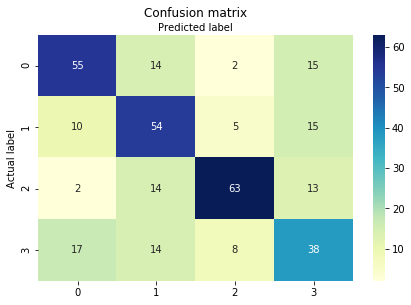

In [238]:
class_names=['Faces', 'Tools', 'Places', 'Body parts'] # Name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  # Creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    # Creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    # Narking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    # Using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

print("\nLogistic Regression")

# Assuming your already have a list of actual_class and predicted_class from the logistic regression classifier
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_test, y_pred)
print(lr_roc_auc_multiclass) #0.25 would be worthless classifier, 1 is perfect

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [74]:
# Evaluate the model and collect the scores - Somatomotor
n_scores_SM = cross_val_score(model, Somatomotor_mean.iloc[:, 3:81], Somatomotor_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Eeport the model performance (M = 0.44, SD = 0.041)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_SM), np.std(n_scores_SM)))

Mean Accuracy: 0.437 (0.041)


In [75]:
# Evaluate the model and collect the scores - Cingulo-Oper
n_scores_CO = cross_val_score(model, Cingulo_Oper_mean.iloc[:, 3:81], Cingulo_Oper_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.47, SD = 0.039)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_CO), np.std(n_scores_CO))) 

Mean Accuracy: 0.474 (0.039)


In [76]:
# Evaluate the model and collect the scores - Language
n_scores_LA = cross_val_score(model, Language_mean.iloc[:, 3:81], Language_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.61, SD = 0.043)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_LA), np.std(n_scores_LA))) 

Mean Accuracy: 0.605 (0.043)


In [77]:
# Evaluate the model and collect the scores - Default
n_scores_DE = cross_val_score(model, Default_mean.iloc[:, 3:81], Default_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.49, SD = 0.039)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_DE), np.std(n_scores_DE)))

Mean Accuracy: 0.492 (0.039)


In [78]:
# Evaluate the model and collect the scores - Frontopariet
n_scores_FP = cross_val_score(model, Frontopariet_mean.iloc[:, 3:81], Frontopariet_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.56, SD = 0.033)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_FP), np.std(n_scores_FP)))

Mean Accuracy: 0.560 (0.033)


In [79]:
# Evaluate the model and collect the scores - Auditory
n_scores_AU = cross_val_score(model, Auditory_mean.iloc[:, 3:81], Auditory_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Eeport the model performance (M = 0.50, SD = 0.036)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_AU), np.std(n_scores_AU)))

Mean Accuracy: 0.502 (0.036)


In [80]:
# Evaluate the model and collect the scores - Dorsal-atten
n_scores_DA = cross_val_score(model, Dorsal_atten_mean.iloc[:, 3:81], Dorsal_atten_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.45, SD = 0.038)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_DA), np.std(n_scores_DA))) 

Mean Accuracy: 0.448 (0.038)


In [81]:
# Evaluate the model and collect the scores - Posterior-Mu
n_scores_PM = cross_val_score(model, Posterior_Mu_mean.iloc[:, 3:81], Posterior_Mu_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.46, SD = 0.041)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_PM), np.std(n_scores_PM)))

Mean Accuracy: 0.459 (0.041)


In [82]:
# Evaluate the model and collect the scores - Orbito-Affec
n_scores_OA = cross_val_score(model, Orbito_Affec_mean.iloc[:, 3:81], Orbito_Affec_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.37, SD = 0.035)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_OA), np.std(n_scores_OA)))

Mean Accuracy: 0.365 (0.035)


In [83]:
# Evaluate the model and collect the scores - Ventral-Mult
n_scores_VM = cross_val_score(model, Ventral_Mult_mean.iloc[:, 3:81], Ventral_Mult_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.49, SD = 0.044)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_VM), np.std(n_scores_VM))) 

Mean Accuracy: 0.489 (0.044)


#### Note: 

Trying out the 2-back task.

In [ ]:
# Return indices to columns (2-back)
X_2back_full_net.reset_index(level=0, inplace=True)
X_2back_full_net.reset_index(level=0, inplace=True)
X_2back_full_net.reset_index(level=0, inplace=True)

In [ ]:
# Visual 2 - 2-back
Visual2_2back = X_2back_full_net.loc[X_2back_full_net['Network'] == 'Visual2']

In [ ]:
# Sanity check
unique(Visual2_2back['Network'])

In [ ]:
# 2-back task

# Evaluate the model and collect the scores - Visual 2
n_scores_V2_2back = cross_val_score(model, Visual2_2back.iloc[:, 3:81], Visual2_2back.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance 
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V2_2back), np.std(n_scores_V2_2back)))

In [ ]:
# See the entire accuracy array
print(n_scores_V2_2back)

#### Note:

Normalization - Jelka

Fourier transform - Alaleh

In [ ]:
# Export the data to deal with it in R
X_2back_full.to_csv("/Users/jelkastojanov/Downloads/Two_back_task_NMA.csv")
X_0back_full.to_csv("/Users/jelkastojanov/Downloads/Zero_back_task_NMA.csv")

In [ ]:
# Import the z-transformed data
WM_0back_z = pd.read_csv("WM_0back_z.csv")
WM_2back_z = pd.read_csv("WM_2back_z.csv")

In [ ]:
WM_0back_z.head()

In [ ]:
del WM_0back_z["Unnamed: 0"]

In [ ]:
WM_2back_z.head()

In [ ]:
del WM_2back_z["Unnamed: 0"]

In [ ]:
WM_0back_z = WM_0back_z.set_index(['Subject_id', 'ROI', 'Network', 'Condition'])
WM_2back_z = WM_2back_z.set_index(['Subject_id', 'ROI', 'Network', 'Condition'])

#### ROI-LEVEL GLM CLASSIFICATION:

In [ ]:
WM_2back_0back_contr_z = WM_2back_z - WM_0back_z

In [ ]:
WM_2back_0back_contr_z.head()

In [ ]:
WM_2back_0back_contr_z.reset_index(level=0, inplace=True)
WM_2back_0back_contr_z.reset_index(level=0, inplace=True)
WM_2back_0back_contr_z.reset_index(level=0, inplace=True)
WM_2back_0back_contr_z.reset_index(level=0, inplace=True)

In [ ]:
Visual1_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Visual1']
Visual2_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Visual2']
Somatomotor_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Somatomotor']
Cingulo_Oper_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Cingulo-Oper']
Language_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Language']
Default_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Default']
Frontopariet_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Frontopariet']
Auditory_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Auditory']
Dorsal_atten_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Dorsal-atten']
Posterior_Mu_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Posterior-Mu']
Orbito_Affec_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Orbito-Affec']
Ventral_Mult_z = WM_2back_0back_contr_z.loc[WM_2back_0back_contr_z['Network'] == 'Ventral-Mult']

In [ ]:
# Evaluate the model and collect the scores - Visual 1
n_scores_V1_ROI_z = cross_val_score(model, Visual1_z.iloc[:, 4:82], Visual1_z.iloc[:, 0], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.486, SD = 0.018)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V1_ROI_z), np.std(n_scores_V1_ROI_z)))

In [ ]:
# Evaluate the model and collect the scores - Visual 2
n_scores_V2_ROI_z = cross_val_score(model, Visual2_z.iloc[:, 4:82], Visual2_z.iloc[:, 0], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.523, SD = 0.004)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V2_ROI_z), np.std(n_scores_V2_ROI_z)))

#### NETWORK-LEVEL (AVERAGE ACTIVITY) GLM CLASSIFICATION:

In [ ]:
WM_0back_z_net = WM_0back_z.groupby(['Subject_id', 'Condition', 'Network']).mean()
WM_2back_z_net = WM_2back_z.groupby(['Subject_id', 'Condition', 'Network']).mean()

In [ ]:
WM_0back_z_net.head()

In [ ]:
WM_2back_z_net.head()

In [ ]:
WM_2back_0back_z_net_contr = WM_2back_z_net - WM_0back_z_net

In [ ]:
WM_2back_0back_z_net_contr.head()

In [ ]:
WM_2back_0back_z_net_contr.reset_index(level=0, inplace=True)
WM_2back_0back_z_net_contr.reset_index(level=0, inplace=True)
WM_2back_0back_z_net_contr.reset_index(level=0, inplace=True)

In [ ]:
# Split networks
Visual1_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Visual1']
Visual2_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Visual2']
Somatomotor_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Somatomotor']
Cingulo_Oper_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Cingulo-Oper']
Language_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Language']
Default_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Default']
Frontopariet_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Frontopariet']
Auditory_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Auditory']
Dorsal_atten_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Dorsal-atten']
Posterior_Mu_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Posterior-Mu']
Orbito_Affec_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Orbito-Affec']
Ventral_Mult_mean_z = WM_2back_0back_z_net_contr.loc[WM_2back_0back_z_net_contr['Network'] == 'Ventral-Mult']

In [ ]:
# Sanity check
Visual1_mean_z.head()

In [ ]:
# Evaluate the model and collect the scores - Visual 1
n_scores_V1_z = cross_val_score(model, Visual1_mean_z.iloc[:, 3:82], Visual1_mean_z.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.540, SD = 0.0032)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V1_z), np.std(n_scores_V1_z)))

In [ ]:
# Evaluate the model and collect the scores - Visual 2
n_scores_V2_z = cross_val_score(model, Visual2_mean_z.iloc[:, 3:82], Visual2_mean_z.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.650, SD = 0.045)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V2_z), np.std(n_scores_V2_z)))

#### Keep all accuracy np.arrays in one place
n_scores_V1

n_scores_V2

n_scores_SM 

n_scores_CO 

n_scores_LA 

n_scores_DE

n_scores_FP 

n_scores_AU 

n_scores_DA 

n_scores_PM 

n_scores_OA 

n_scores_VM

In [106]:
# Merge accuracy outputs for all networks
Visual1_acc = pd.DataFrame(n_scores_V1, columns = ['Primary visual cortex'])
Visual2_acc = pd.DataFrame(n_scores_V2, columns = ['Secondary visual cortex'])
SM_acc = pd.DataFrame(n_scores_SM, columns = ['Somatomotor network'])
CO_acc = pd.DataFrame(n_scores_CO, columns = ['Cingulo-opercular network'])
LA_acc = pd.DataFrame(n_scores_LA, columns = ['Language network'])
DE_acc = pd.DataFrame(n_scores_DE, columns = ['Default network'])
FP_acc = pd.DataFrame(n_scores_FP, columns = ['Frontoparietal network'])
AU_acc = pd.DataFrame(n_scores_AU, columns = ['Auditory network'])
DA_acc = pd.DataFrame(n_scores_DA, columns = ['Dorsal attention network'])
PM_acc = pd.DataFrame(n_scores_PM, columns = ['Posterior medial network'])
OA_acc = pd.DataFrame(n_scores_OA, columns = ['Orbito-affective network'])
VM_acc = pd.DataFrame(n_scores_VM, columns = ['Ventral attention network'])

Network_GLMAccuracy = pd.concat([Visual1_acc, Visual2_acc, SM_acc, CO_acc, LA_acc, DE_acc, FP_acc, AU_acc, DA_acc, PM_acc, OA_acc, VM_acc], axis=1)

# Export to make shiny plots in R
Network_GLMAccuracy.to_csv('Network_GLMAccuracy.csv')

#### SUPPORT VECTOR MACHINE

In [143]:
# SVM classifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [144]:
SVM_class = SVC(kernel='rbf', decision_function_shape='ovo') 

In [145]:
C_space = np.logspace(-2, 10, 13)
gamma_space = np.logspace(-9, 3, 13)
param_grid = {'C': c_space, 'gamma': gamma_space}

In [177]:
# Sanity check
param_grid

{'C': array([1.00000000e-03, 1.58842105e-01, 3.16684211e-01, 4.74526316e-01,
        6.32368421e-01, 7.90210526e-01, 9.48052632e-01, 1.10589474e+00,
        1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
        1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
        2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
 'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
        1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [146]:
SVM_cv = GridSearchCV(SVM_class, param_grid, cv = 10)

#### Visual 1

In [ ]:
# Fitting on a network level to obtain parameter
SVM_cv.fit(Visual1_mean.iloc[:, 3:82], Visual1_mean.iloc[:, 1])

In [87]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 0.6323684210526316, gamma = 0.000001

{'C': 0.6323684210526316, 'gamma': 1e-06}

In [88]:
# Best accuracy score
SVM_cv.best_score_

0.5663716814159292

In [147]:
# Specifying SVM parameters 

#V1-specific
SVM_class_V1 = SVC(kernel='rbf', decision_function_shape='ovo', C = 0.6323684210526316, gamma = 0.000001) 

In [148]:
# Calculate accuracy (30 points) - V1 
V1_SVM = cross_val_score(SVM_class_V1, Visual1_mean.iloc[:, 3:82], Visual1_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (V1_SVM.mean(), V1_SVM.std()))

0.57 accuracy with a standard deviation of 0.07


In [228]:
# Merge accuracy outputs for all networks
Visual1_SVM_acc = pd.DataFrame(V1_SVM, columns = ['Primary visual cortex'])
Visual2_SVM_acc = pd.DataFrame(V2_SVM, columns = ['Secondary visual cortex'])
SM_SVM_acc = pd.DataFrame(SM_SVM, columns = ['Somatomotor network'])
CO_SVM_acc = pd.DataFrame(CO_SVM, columns = ['Cingulo-opercular network'])
LA_SVM_acc = pd.DataFrame(LA_SVM, columns = ['Language network'])
DE_SVM_acc = pd.DataFrame(DE_SVM, columns = ['Default network'])
FP_SVM_acc = pd.DataFrame(FP_SVM, columns = ['Frontoparietal network'])
AU_SVM_acc = pd.DataFrame(AU_SVM, columns = ['Auditory network'])
DA_SVM_acc = pd.DataFrame(DA_SVM, columns = ['Dorsal attention network'])
PM_SVM_acc = pd.DataFrame(PM_SVM, columns = ['Posterior medial network'])
OA_SVM_acc = pd.DataFrame(OA_SVM, columns = ['Orbito-affective network'])
VM_SVM_acc = pd.DataFrame(VM_SVM, columns = ['Ventral attention network'])

Network_SVM_Accuracy = pd.concat([Visual1_SVM_acc, Visual2_SVM_acc, SM_SVM_acc, CO_SVM_acc, LA_SVM_acc, DE_SVM_acc, FP_SVM_acc, AU_SVM_acc, DA_SVM_acc, PM_SVM_acc, OA_SVM_acc, VM_SVM_acc], axis=1)

# Export to make shiny plots in R
Network_SVM_Accuracy.to_csv('Network_SVM_Accuracy.csv')

#### Visual 2

In [153]:
SVM_cv.fit(Visual2_mean.iloc[:, 3:82], Visual2_mean.iloc[:, 1])

/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [154]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 2.3686315789473684, gamma = 0.000001

{'C': 2.3686315789473684, 'gamma': 1e-06}

In [155]:
# Best accuracy score
SVM_cv.best_score_

0.6858407079646017

In [156]:
# Specifying SVM parameters 

#V2-specific
SVM_class_V2 = SVC(kernel='rbf', decision_function_shape='ovo', C = 2.3686315789473684, gamma = 0.000001) 

In [157]:
# Calculate accuracy (30 points) - V2
V2_SVM = cross_val_score(SVM_class_V2, Visual2_mean.iloc[:, 3:82], Visual2_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (V2_SVM.mean(), V2_SVM.std()))

0.68 accuracy with a standard deviation of 0.07


#### Somatomotor

In [161]:
SVM_cv.fit(Somatomotor_mean.iloc[:, 3:82], Somatomotor_mean.iloc[:, 1])

/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [162]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 3.0, gamma = 0.000001

{'C': 3.0, 'gamma': 1e-06}

In [163]:
# Best accuracy score
SVM_cv.best_score_

0.4889380530973451

In [164]:
# Specifying SVM parameters 

#SM-specific
SVM_class_SM = SVC(kernel='rbf', decision_function_shape='ovo', C = 3.0, gamma = 0.000001) 

In [165]:
# Calculate accuracy (30 points) - SM 
SM_SVM = cross_val_score(SVM_class_SM, Somatomotor_mean.iloc[:, 3:82], Somatomotor_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (SM_SVM.mean(), SM_SVM.std()))

0.49 accuracy with a standard deviation of 0.07


#### Cingulo-opercular 

In [167]:
SVM_cv.fit(Cingulo_Oper_mean.iloc[:, 3:82], Cingulo_Oper_mean.iloc[:, 1])

/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [168]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 2.526473684210526, gamma = 0.000001

{'C': 2.526473684210526, 'gamma': 1e-06}

In [169]:
# Best accuracy score
SVM_cv.best_score_

0.5294985250737463

In [170]:
# Specifying SVM parameters 

#CO-specific
SVM_class_CO = SVC(kernel='rbf', decision_function_shape='ovo', C = 2.526473684210526, gamma = 0.000001) 

In [171]:
# Calculate accuracy (30 points) - CO
CO_SVM = cross_val_score(SVM_class_CO, Cingulo_Oper_mean.iloc[:, 3:82], Cingulo_Oper_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (CO_SVM.mean(), CO_SVM.std()))

0.52 accuracy with a standard deviation of 0.07


#### Language

In [175]:
SVM_cv.fit(Language_mean.iloc[:, 3:82], Language_mean.iloc[:, 1])

/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [176]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 1.8951052631578946, gamma = 0.000001

{'C': 1.8951052631578946, 'gamma': 1e-06}

In [178]:
# Best accuracy score
SVM_cv.best_score_

0.6482300884955752

In [179]:
# Specifying SVM parameters 

#LA-specific
SVM_class_LA = SVC(kernel='rbf', decision_function_shape='ovo', C = 1.8951052631578946, gamma = 0.000001) 

In [180]:
# Calculate accuracy (30 points) - LA
LA_SVM = cross_val_score(SVM_class_LA, Language_mean.iloc[:, 3:82], Language_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (LA_SVM.mean(), LA_SVM.std()))

0.65 accuracy with a standard deviation of 0.07


#### Default

In [182]:
SVM_cv.fit(Default_mean.iloc[:, 3:82], Default_mean.iloc[:, 1])

/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [183]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 2.8421578947368418, gamma = 0.000001

{'C': 2.8421578947368418, 'gamma': 1e-06}

In [184]:
# Best accuracy score
SVM_cv.best_score_

0.5457227138643068

In [185]:
# Specifying SVM parameters 

# DE-specific
SVM_class_DE = SVC(kernel='rbf', decision_function_shape='ovo', C = 2.8421578947368418, gamma = 0.000001) 

In [186]:
# Calculate accuracy (30 points) - DE
DE_SVM = cross_val_score(SVM_class_DE, Default_mean.iloc[:, 3:82], Default_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (DE_SVM.mean(), DE_SVM.std()))

0.54 accuracy with a standard deviation of 0.08


#### Frontoparietal

In [188]:
SVM_cv.fit(Frontopariet_mean.iloc[:, 3:82], Frontopariet_mean.iloc[:, 1])

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [189]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 1.8951052631578946, gamma = 0.000001

{'C': 1.8951052631578946, 'gamma': 1e-06}

In [190]:
# Best accuracy score
SVM_cv.best_score_

0.5899705014749262

In [191]:
# Specifying SVM parameters 

# FP-specific
SVM_class_FP = SVC(kernel='rbf', decision_function_shape='ovo', C = 1.8951052631578946, gamma = 0.000001) 

In [192]:
# Calculate accuracy (30 points) - FP
FP_SVM = cross_val_score(SVM_class_FP, Frontopariet_mean.iloc[:, 3:82], Frontopariet_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (FP_SVM.mean(), FP_SVM.std()))

0.59 accuracy with a standard deviation of 0.07


#### Auditory

In [195]:
SVM_cv.fit(Auditory_mean.iloc[:, 3:82], Auditory_mean.iloc[:, 1])

/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [196]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 0.3166842105263158, gamma = 0.000001

{'C': 0.3166842105263158, 'gamma': 1e-06}

In [197]:
# Best accuracy score
SVM_cv.best_score_

0.5553097345132744

In [198]:
# Specifying SVM parameters 

# AU-specific
SVM_class_AU = SVC(kernel='rbf', decision_function_shape='ovo', C = 0.3166842105263158, gamma = 0.000001) 

In [199]:
# Calculate accuracy (30 points) - AU
AU_SVM = cross_val_score(SVM_class_AU, Auditory_mean.iloc[:, 3:82], Auditory_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (AU_SVM.mean(), AU_SVM.std()))

0.55 accuracy with a standard deviation of 0.08


#### Dorsal attention

In [201]:
SVM_cv.fit(Dorsal_atten_mean.iloc[:, 3:82], Dorsal_atten_mean.iloc[:, 1])

/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [202]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 2.526473684210526, gamma = 0.000001

{'C': 2.526473684210526, 'gamma': 1e-06}

In [203]:
# Best accuracy score
SVM_cv.best_score_

0.4948377581120944

In [204]:
# Specifying SVM parameters 

# DA-specific
SVM_class_DA = SVC(kernel='rbf', decision_function_shape='ovo', C = 2.526473684210526, gamma = 0.000001) 

In [205]:
# Calculate accuracy (30 points) - DA
DA_SVM = cross_val_score(SVM_class_DA, Dorsal_atten_mean.iloc[:, 3:82], Dorsal_atten_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (DA_SVM.mean(), DA_SVM.std()))

0.49 accuracy with a standard deviation of 0.07


#### Posterior medial

In [207]:
SVM_cv.fit(Posterior_Mu_mean.iloc[:, 3:82], Posterior_Mu_mean.iloc[:, 1])

/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [208]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 0.9480526315789474, gamma = 1e-05

{'C': 0.9480526315789474, 'gamma': 1e-05}

In [209]:
# Best accuracy score
SVM_cv.best_score_

0.5036873156342183

In [210]:
# Specifying SVM parameters 

# PM-specific
SVM_class_PM = SVC(kernel='rbf', decision_function_shape='ovo', C = 0.9480526315789474, gamma = 0.00001) 

In [211]:
# Calculate accuracy (30 points) - PM
PM_SVM = cross_val_score(SVM_class_PM, Posterior_Mu_mean.iloc[:, 3:82], Posterior_Mu_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (PM_SVM.mean(), PM_SVM.std()))

0.50 accuracy with a standard deviation of 0.08


#### Orbito-affective

In [215]:
SVM_cv.fit(Orbito_Affec_mean.iloc[:, 3:82], Orbito_Affec_mean.iloc[:, 1])

/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [216]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 2.2107894736842106, gamma = 1e-07

{'C': 2.2107894736842106, 'gamma': 1e-07}

In [217]:
# Best accuracy score
SVM_cv.best_score_

0.37389380530973454

In [218]:
# Specifying SVM parameters 

# OA-specific
SVM_class_OA = SVC(kernel='rbf', decision_function_shape='ovo', C = 2.2107894736842106, gamma = 0.0000001) 

In [219]:
# Calculate accuracy (30 points) - OA
OA_SVM = cross_val_score(SVM_class_OA, Orbito_Affec_mean.iloc[:, 3:82], Orbito_Affec_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (OA_SVM.mean(), OA_SVM.std()))

0.37 accuracy with a standard deviation of 0.06


#### Ventral attention

In [223]:
SVM_cv.fit(Ventral_Mult_mean.iloc[:, 3:82], Ventral_Mult_mean.iloc[:, 1])

/Users/jelkastojanov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 1.58842105e...
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos

In [224]:
# Best gamma and C parameters
SVM_cv.best_params_ # C = 1.5794210526315788, gamma = 1e-06

{'C': 1.5794210526315788, 'gamma': 1e-06}

In [225]:
# Best accuracy score
SVM_cv.best_score_

0.556047197640118

In [226]:
# Specifying SVM parameters 

# VM-specific
SVM_class_VM = SVC(kernel='rbf', decision_function_shape='ovo', C = 1.5794210526315788, gamma = 0.000001) 

In [227]:
# Calculate accuracy (30 points) - VM
VM_SVM = cross_val_score(SVM_class_VM, Ventral_Mult_mean.iloc[:, 3:82], Ventral_Mult_mean.iloc[:, 1], cv = 30)

print("%0.2f accuracy with a standard deviation of %0.2f" % (VM_SVM.mean(), VM_SVM.std()))

0.56 accuracy with a standard deviation of 0.09
